### Import the necessary libraries

In [1]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

import numpy as np

from scipy.signal import butter, filtfilt

from scipy.stats import skew, kurtosis

from scipy.signal import welch

from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans

from sklearn.decomposition import PCA

from sklearn.metrics import silhouette_score

### Read the datasets

In [2]:
df = pd.read_csv('../datasets/imu_data.csv')

In [3]:
df.head()

,accelerometer,gyro,surface
0,0.903738,1.698736,asphalt
1,0.834571,2.051725,asphalt
2,1.160288,0.895211,asphalt
3,1.106549,1.276459,asphalt
4,0.931808,4.475666,asphalt


### Pre-Processing

#### Filtering

As seen in  the exploratory data analysis, the IMU acceleration data captured from the rollator movement includes both the high-frequency acceleration due to movement and the low-frequeny acceleration due to gravity. To accurately classify surfaces based on the rollator's movement, it's crucial to eliminate the noise introduced by gravitational acceleration. 

We will employ a high-pass Butterworth filter to achive this.

In [4]:
#Getting subsets of the dataframe df for each surfaces.

asphalt_df = df[df['surface'] == 'asphalt'].reset_index(drop = True)

concrete_df = df[df['surface'] == 'concrete'].reset_index(drop = True)

grass_df = df[df['surface'] == 'grass'].reset_index(drop = True)

stone_df = df[df['surface'] == 'stones'].reset_index(drop = True)

tile_df = df[df['surface'] == 'tile'].reset_index(drop = True)

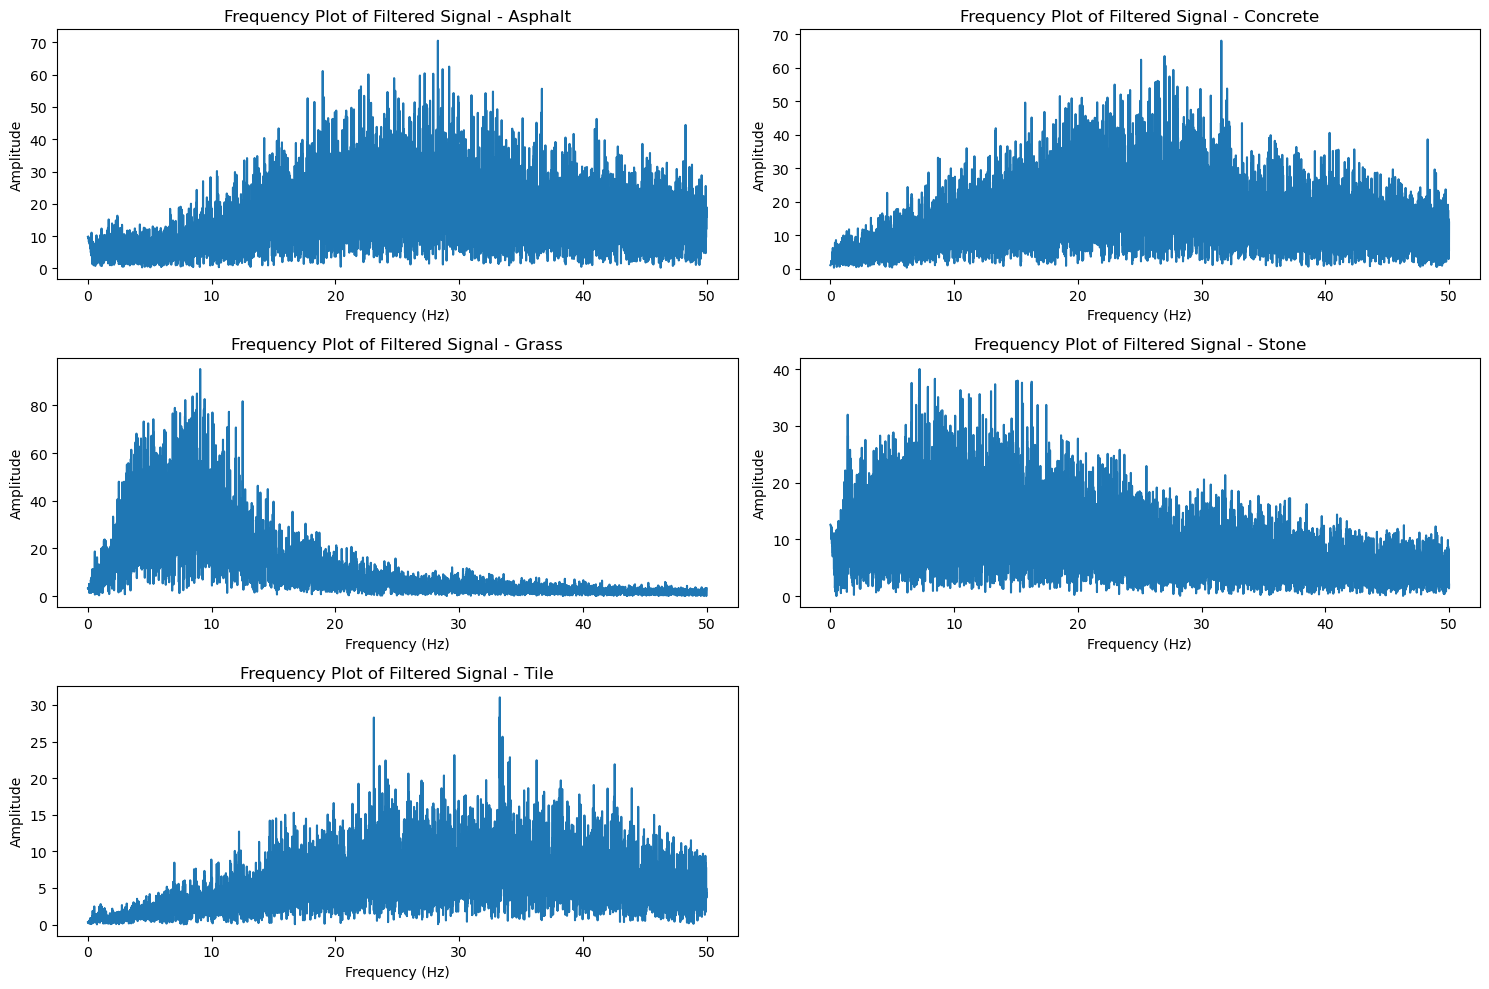

In [5]:
fs = 100  # Sampling frequency

cutoff = 0.25 # Cut off frequency

b, a = butter(N = 1, Wn = cutoff / (0.5*fs), btype = 'high', analog=False)

dataframe_list = [asphalt_df, concrete_df, grass_df, stone_df, tile_df]

names_list = ['Asphalt', 'Concrete', 'Grass', 'Stone', 'Tile']

plt.figure(figsize = (15, 10))

for index, (df, name) in enumerate(zip(dataframe_list, names_list)):

    df['filtered accelerometer'] = filtfilt(b, a, df['accelerometer'])

    fft_result_filtered = np.fft.fft(df['filtered accelerometer'])

    fft_freq_filtered = np.fft.fftfreq(len(df['filtered accelerometer']), 1/fs)

    positive_freqs = fft_freq_filtered > 0

    plt.subplot(3, 2, index + 1)
    
    plt.plot(fft_freq_filtered[positive_freqs], np.abs(fft_result_filtered[positive_freqs]))
    
    plt.title(f'Frequency Plot of Filtered Signal - {name}')
    
    plt.xlabel('Frequency (Hz)')
    
    plt.ylabel('Amplitude')

plt.tight_layout()

plt.show()

From the Frequency domain plot, the high amplitudes at the very low frequency (0 Hz) has been reduced, indicating a decrease in the impact of gravitational acceleration.

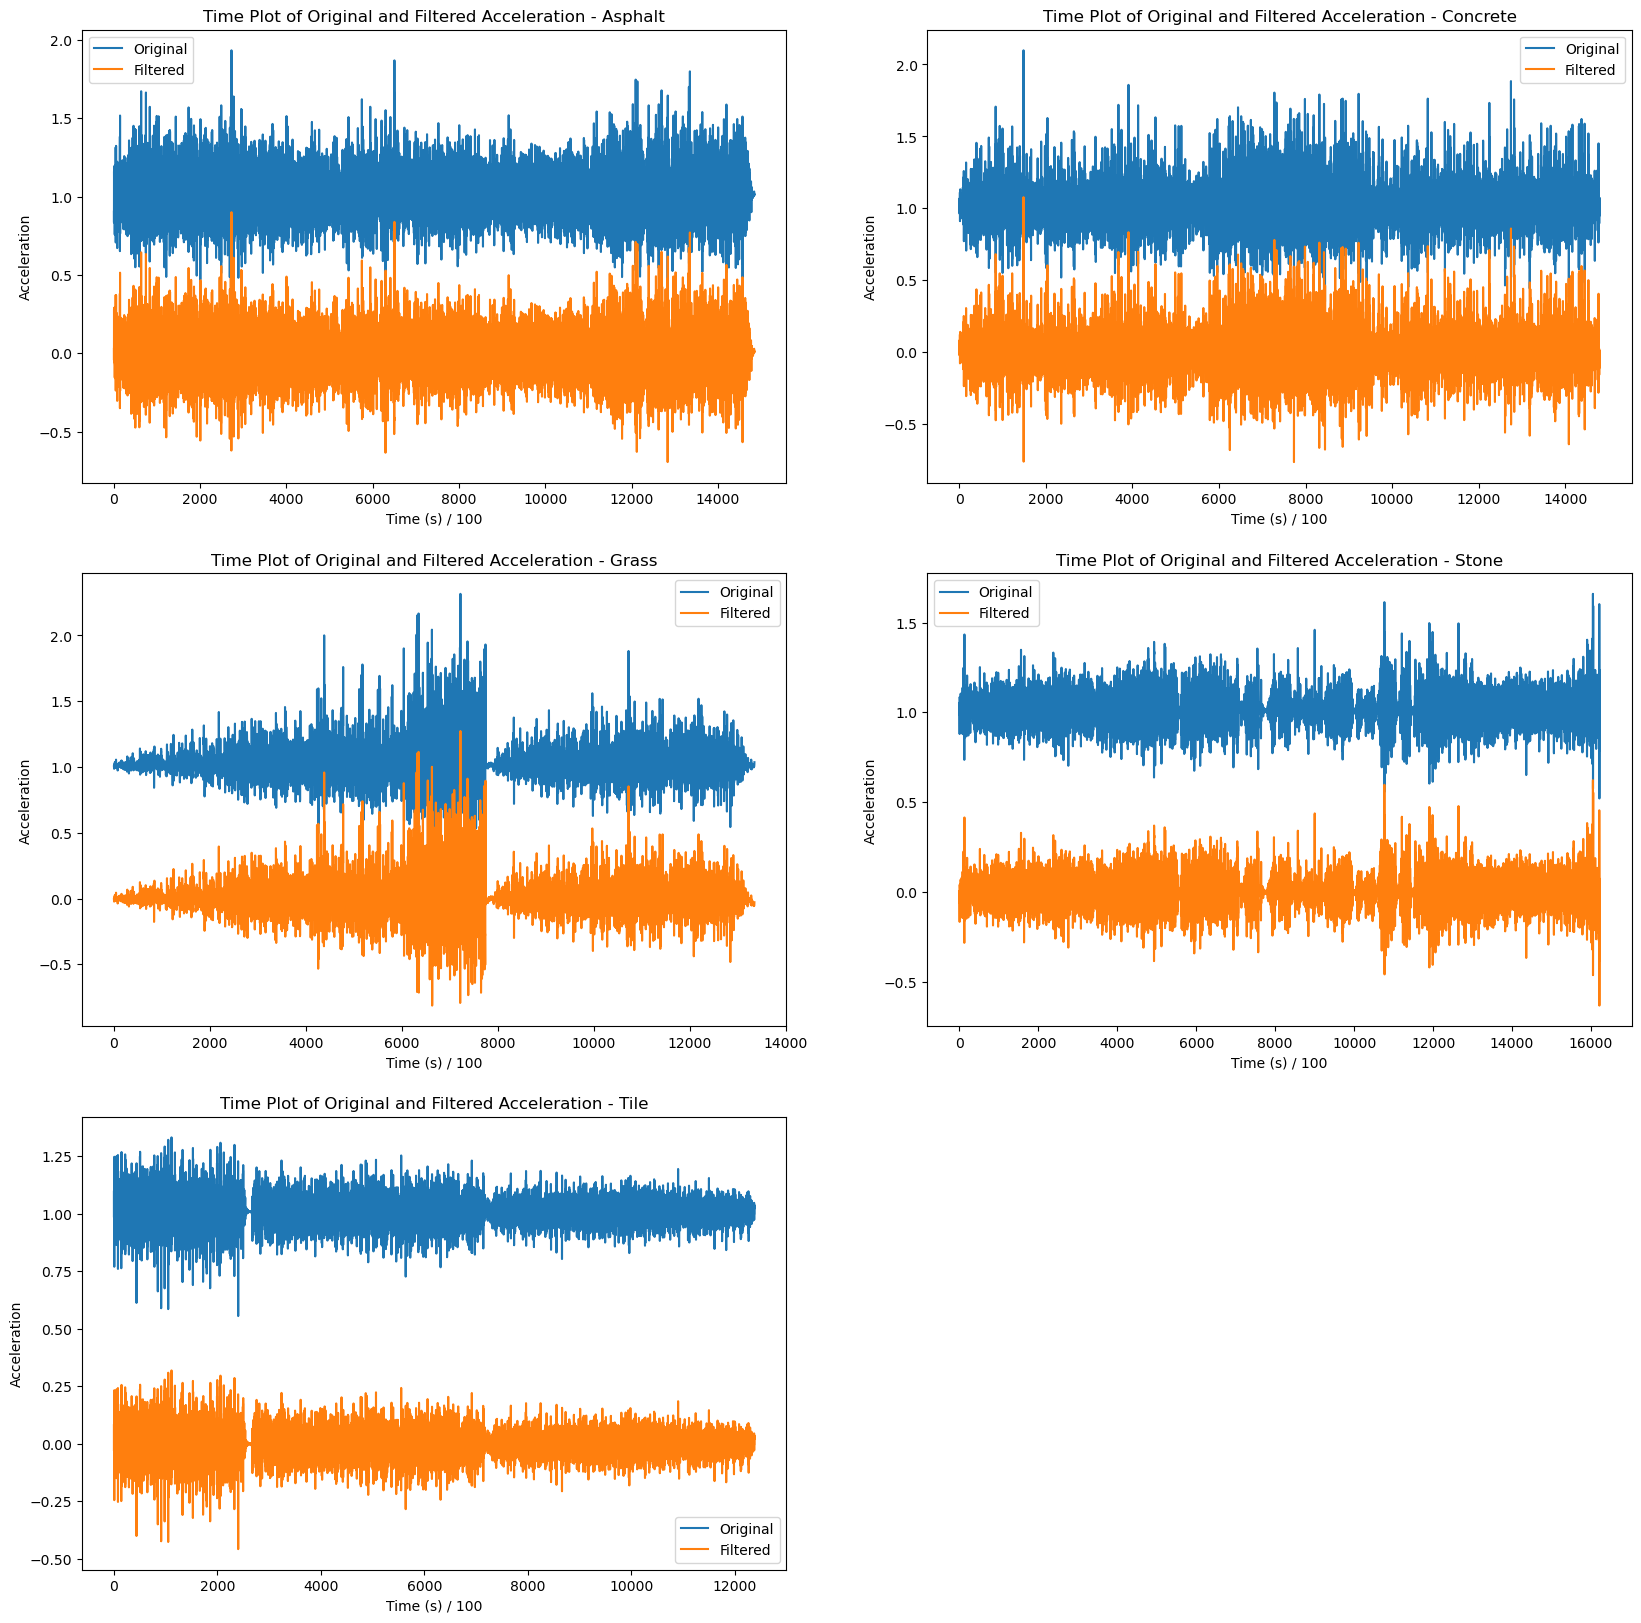

In [6]:
plt.figure(figsize = (20, 20))

for index, (df, name) in enumerate(zip(dataframe_list, names_list)):

    plt.subplot(3, 2, index + 1)

    plt.plot(df['accelerometer'], label = 'Original')

    plt. plot(df['filtered accelerometer'], label = 'Filtered')

    plt.title(f'Time Plot of Original and Filtered Acceleration - {name}')

    plt.xlabel('Time (s) / 100')

    plt.ylabel('Acceleration')

    plt.legend()

The time plots comparing the original and filtered acceleration shows that the filtered acceleration consistently trends below the original. This indicates a reduction or removal of the gravitational acceleration. However, the overall pattern of both the original and filtered accelerations remains unchanged.

#### Clustering

As part of the preprocessing, we will employ clustering. 

This involves using the sliding window technique to partition data into windows based on a defined window size. Features extracted from each window will serve as input for the clustering algorithm. To ensure effective clustering, windows will not overlap across different surfaces, and any windows that do not meet the specififed size will be discarded.

In [7]:
# Bring the surface datasets together as one, drop the accelerometer column and re-arrange the columns

df2 = pd.concat([asphalt_df, concrete_df, grass_df, stone_df, tile_df], axis = 0 )

df2 = df2.drop(['accelerometer'], axis = 1)

df2 = df2.iloc[:, [2,0,1]]

df2 = df2.reset_index(drop = True)

df2.head()

,filtered accelerometer,gyro,surface
0,0.028466,1.698736,asphalt
1,-0.042912,2.051725,asphalt
2,0.280607,0.895211,asphalt
3,0.224717,1.276459,asphalt
4,0.047872,4.475666,asphalt


In [8]:
df2.to_csv('imu_data_filtered.csv', index = False)

#### Sliding Window

In [8]:
def sliding_window(df, window_size):
    
    groups = []
    
    current_group = []
    
    current_surface = None  

    for index, row in df.iterrows():
        
        if current_surface is None:
            
            current_surface = row['surface']  

        if row['surface'] == current_surface:
            
            current_group.append((row['filtered accelerometer'], row['gyro']))

            if len(current_group) == window_size:
                
                groups.append((current_group, current_surface)) 
                
                current_group = [] 

        else:
            
            if len(current_group) == window_size:
                
                groups.append((current_group, current_surface))

            current_group = [(row['filtered accelerometer'], row['gyro'])]
            
            current_surface = row['surface']
            
    if len(current_group) == window_size:
        
        groups.append((current_group, current_surface))

    return groups


#### Feature Extraction

In [9]:
# Define functions that calculate the different features we want to extract from each window

def calculate_mean(data):
    
    accelerometer_mean = np.mean([x[0] for x in data[0]])
    
    gyro_mean = np.mean([x[1] for x in data[0]])
    
    return accelerometer_mean, gyro_mean

def calculate_std(data):
    
    accelerometer_std = np.std([x[0] for x in data[0]])  
    
    gyro_std = np.std([x[1] for x in data[0]]) 
    
    return accelerometer_std, gyro_std

def calculate_max(data):
    
    accelerometer_max = np.max([x[0] for x in data[0]]) 
    
    gyro_max = np.max([x[1] for x in data[0]])  
    
    return accelerometer_max, gyro_max

def calculate_min(data):
    
    accelerometer_min = np.min([x[0] for x in data[0]]) 
    
    gyro_min = np.min([x[1] for x in data[0]]) 
    
    return accelerometer_min, gyro_min

def calculate_iqr(data):
    
    accelerometer_iqr = np.percentile([x[0] for x in data[0]], 75) - np.percentile([x[0] for x in data[0]], 25)
    
    gyro_iqr = np.percentile([x[1] for x in data[0]], 75) - np.percentile([x[1] for x in data[0]], 25)
    
    return accelerometer_iqr, gyro_iqr

def calculate_skewness(data):
    
    accelerometer_skew = skew([x[0] for x in data[0]])
    
    gyro_skew = skew([x[1] for x in data[0]])
    
    return accelerometer_skew, gyro_skew

def calculate_kurtosis(data):
    
    accelerometer_kurt = kurtosis([x[0] for x in data[0]])
    
    gyro_kurt = kurtosis([x[1] for x in data[0]])
    
    return accelerometer_kurt, gyro_kurt
    
def calculate_fft_peak(data):
    
    fft_acc = np.fft.fft([x[0] for x in data[0]])
    
    fft_gyro = np.fft.fft([x[1] for x in data[0]])
    
    mag_acc = np.abs(fft_acc)
    
    mag_gyro = np.abs(fft_gyro)
    
    peak_index_acc = np.argmax(mag_acc)
    
    peak_index_gyro = np.argmax(mag_gyro)
    
    peak_amplitude_acc = mag_acc[peak_index_acc]
    
    peak_amplitude_gyro = mag_gyro[peak_index_gyro]
    
    return peak_amplitude_acc, peak_amplitude_gyro

def calculate_psd(data):
    
    accelerometer_data = np.array([x[0] for x in data[0]])
    
    gyro_data = np.array([x[1] for x in data[0]])

    f_acc, psd_acc = welch(accelerometer_data, fs=100, nperseg=100)  
    
    f_gyro, psd_gyro = welch(gyro_data, fs=100, nperseg=100)  

    peak_freq_acc = f_acc[np.argmax(psd_acc)]
    
    peak_power_acc = np.max(psd_acc)
    
    peak_freq_gyro = f_gyro[np.argmax(psd_gyro)]
    
    peak_power_gyro = np.max(psd_gyro)

    return peak_freq_acc, peak_power_acc, peak_freq_gyro, peak_power_gyro

def extract_surface(data):

    surface = data[1]

    return surface

In [10]:
def extract_features(segments):
    
    features_list = []
    
    for segment in segments:

        psd_features = calculate_psd(segment)
        
        features = {
            'accelerometer_mean': calculate_mean(segment)[0],
            'gyro_mean': calculate_mean(segment)[1],
            'accelerometer_std': calculate_std(segment)[0],
            'gyro_std': calculate_std(segment)[1],
            'accelerometer_max': calculate_max(segment)[0],
            'gyro_max': calculate_max(segment)[1],
            'accelerometer_min': calculate_min(segment)[0],
            'gyro_min': calculate_min(segment)[1],
            'accelerometer_iqr': calculate_iqr(segment)[0],
            'gyro_iqr': calculate_iqr(segment)[1],
            'accelerometer_skewness': calculate_skewness(segment)[0],
            'gyro_skewness': calculate_skewness(segment)[1],
            'accelerometer_kurtosis': calculate_kurtosis(segment)[0],
            'gyro_kurtosis': calculate_kurtosis(segment)[1],
            'accelerometer_fft_peak_amplitude': calculate_fft_peak(segment)[0],
            'gyro_fft_peak_amplitude': calculate_fft_peak(segment)[1],
            'accelerometer_peak_freq': psd_features[0],
            'accelerometer_peak_power': psd_features[1],
            'gyro_peak_freq': psd_features[2],
            'gyro_peak_power': psd_features[3],
            'surface': extract_surface(segment)
        }
        features_list.append(features)
    
    return features_list


#### K-Means

In [11]:
def silhouette_score_func(features_df, j):

    df_scaled = StandardScaler().fit_transform(features_df)

    pca = PCA(n_components = j)

    df_pca = pca.fit_transform(df_scaled)

    kmeans = KMeans(n_clusters = 5, random_state = 42)

    kmeans.fit(df_pca)

    labels = kmeans.labels_

    score = silhouette_score(df_pca, labels)

    return score

In [12]:
window_size_list = range(100, 3100, 100)

pca_component_list = range(2, 10, 1)

In [13]:
just_some_list = []

for i in window_size_list:

    windows_data_list = sliding_window(df2, i)

    features_list = extract_features(windows_data_list)

    features_df = pd.DataFrame(features_list)

    X = features_df.drop('surface', axis = 1)

    Y = features_df['surface']

    for j in pca_component_list:
        
        score = silhouette_score_func(X, j)

        new_list = {

            'window size': i,

            'pca components' : j,

            'silhouette score' : score

        }

        just_some_list.append(new_list)

C:\Users\Oladayo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Oladayo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\Oladayo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Oladayo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the e

In [14]:
df3 = pd.DataFrame(just_some_list)

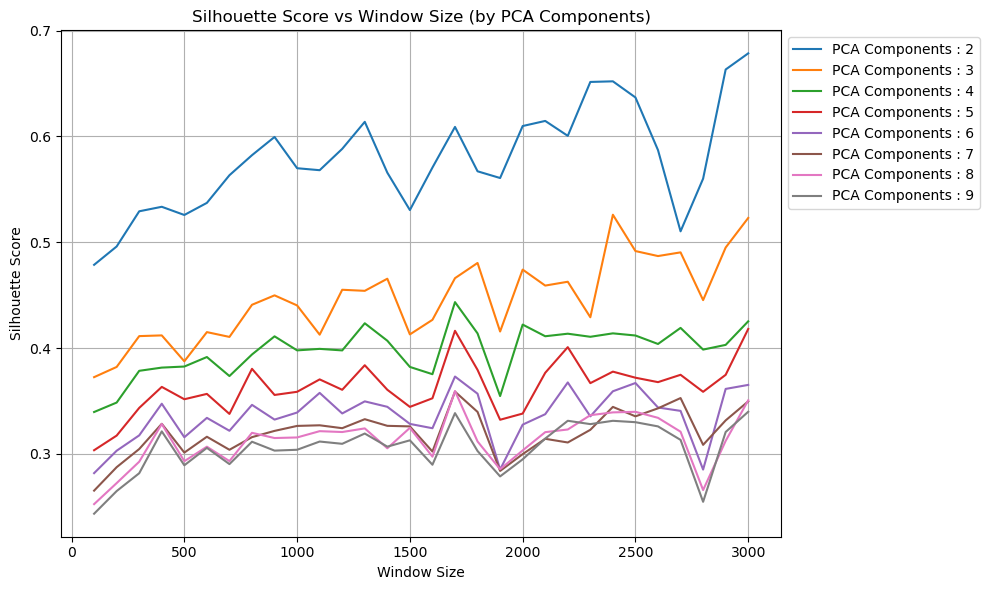

In [15]:
unique_pca_components = df3['pca components'].unique()

plt.figure(figsize = (10, 6))

for i in unique_pca_components:

    pca_data = df3[df3['pca components'] == i]

    window_size = pca_data['window size']

    silhouette_score = pca_data['silhouette score']

    plt.plot(window_size, silhouette_score, label = f'PCA Components : {i}')

plt.xlabel('Window Size')

plt.ylabel('Silhouette Score')

plt.title('Silhouette Score vs Window Size (by PCA Components)')

plt.legend(bbox_to_anchor=(1.0, 1.0), loc = 'upper left')

plt.grid(True)

plt.tight_layout()

plt.show()

The best Silhouette score (which indicate quality of the clustering) occurred at when there are 2 components (PCA 1 and PCA2)

In [16]:
df3.to_csv('check.csv', index = False)

In [17]:
windows_data = sliding_window(df2, 900)

In [18]:
extracted_features_list = extract_features(windows_data)

In [19]:
features_df = pd.DataFrame(extracted_features_list)

In [20]:
features_df

,accelerometer_mean,gyro_mean,accelerometer_std,gyro_std,accelerometer_max,gyro_max,accelerometer_min,gyro_min,accelerometer_iqr,gyro_iqr,...,gyro_skewness,accelerometer_kurtosis,gyro_kurtosis,accelerometer_fft_peak_amplitude,gyro_fft_peak_amplitude,accelerometer_peak_freq,accelerometer_peak_power,gyro_peak_freq,gyro_peak_power,surface
0,0.009911,4.044588,0.149418,1.765136,0.644196,10.470187,-0.473554,0.316045,0.184387,2.324899,...,0.551599,0.919643,0.139150,12.141595,3640.129516,29.0,0.001414,1.0,0.400908,asphalt
1,0.000007,4.339178,0.153996,2.061404,0.544369,15.012360,-0.535466,0.364618,0.196107,2.977598,...,0.692094,0.427543,0.751399,14.898579,3905.260611,27.0,0.001194,1.0,0.715878,asphalt
2,-0.000189,4.839379,0.168194,2.072937,0.556465,12.483871,-0.556234,0.604603,0.216926,2.904947,...,0.463759,0.242428,0.017247,19.767777,4355.441333,27.0,0.001764,1.0,0.612785,asphalt
3,0.000014,5.350240,0.169821,2.693302,0.900636,17.694543,-0.620048,0.470308,0.203515,3.702353,...,0.935506,1.629930,1.053015,14.509044,4815.215587,20.0,0.001224,1.0,1.052198,asphalt
4,0.000372,5.578424,0.141160,2.678211,0.489566,15.211358,-0.454959,0.177947,0.180307,3.868781,...,0.516151,0.283429,-0.285578,13.000702,5020.581548,24.0,0.000804,1.0,1.834689,asphalt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,-0.000140,1.501629,0.041978,0.667861,0.176372,4.317941,-0.148570,0.112129,0.048279,0.973721,...,0.438548,0.950725,0.089962,4.355585,1351.465922,20.0,0.000146,1.0,0.043080,tile
73,0.000064,2.467112,0.047016,1.479137,0.176415,9.076928,-0.206634,0.074753,0.057646,1.498402,...,1.483116,1.057033,2.439310,5.415508,2220.400543,22.0,0.000123,1.0,0.611716,tile
74,0.000039,2.391299,0.049591,1.424116,0.152992,8.027138,-0.155672,0.244617,0.063135,1.744832,...,1.112205,0.111408,0.893913,4.933074,2152.169013,23.0,0.000136,1.0,0.580516,tile
75,-0.000138,1.979372,0.049349,0.929927,0.154776,5.546606,-0.181214,0.151054,0.062331,1.274860,...,0.665569,0.220820,0.468337,5.865659,1781.435217,25.0,0.000160,1.0,0.159291,tile


In [21]:
data = features_df.drop('surface', axis = 1)

target = features_df['surface'].astype('category').cat.codes.values

features_names = features_df.columns[:-1]

target_names = features_df['surface'].astype('category').cat.categories

In [22]:
target_names

Index(['asphalt', 'concrete', 'grass', 'stones', 'tile'], dtype='object')

In [24]:
dataset = {
    'data': np.array(data),
    'target': np.array(target),
    'target_names': np.array(target_names),
}

In [25]:
data = dataset['data']

data_scaled = StandardScaler().fit_transform(data)

pca = PCA(n_components = 2) 

pca_components = pca.fit_transform(data_scaled)

In [26]:
kmeans = KMeans(n_clusters = 5, random_state = 42)

kmeans.fit(pca_components)

labels = kmeans.labels_

C:\Users\Oladayo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Oladayo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


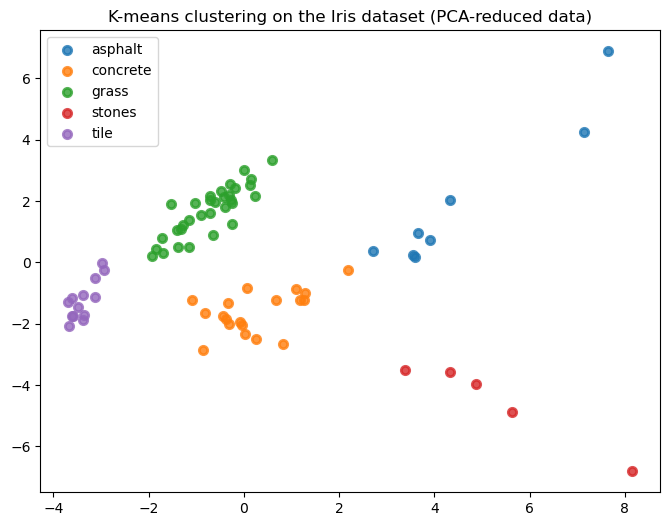

In [27]:
plt.figure(figsize = (8, 6))

lw = 2

for i, target_name in zip([0, 1, 2, 3, 4], dataset['target_names']):
    
    plt.scatter(pca_components[labels == i, 0], pca_components[labels == i, 1], alpha = .8, lw = lw,
               
               label = target_name)
    
plt.legend(loc = 'best', shadow = False, scatterpoints = 1)

plt.title('K-means clustering on the Iris dataset (PCA-reduced data)')

plt.show()

In [29]:
pca = PCA().fit(data_scaled)

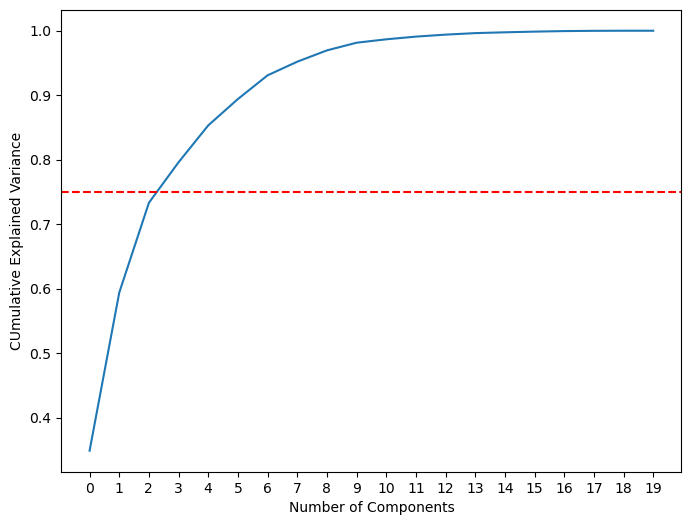

In [36]:
plt.figure(figsize = (8, 6))

plt.plot(np.cumsum(pca.explained_variance_ratio_))

plt.xlabel('Number of Components')

plt.ylabel('CUmulative Explained Variance')

plt.axhline(y = 0.75, color = 'r', linestyle = '--')

plt.xticks(range(20))

plt.show()